# Observation on Uninsured Rates in the U.S.

**Subtitle:** Which group of people are not likely to be insured?

**Author:** Seyoung Jung 


__Abstract:__ 

The dataset used for this project was obtained from the [United States Census Bureau](https://www.census.gov/data/developers/data-sets/Health-Insurance-Statistics.html). In order to access to the data and reproduce this analysis, one needs to have their own API keys. You can directly request a key by singing up on this [page](https://api.census.gov/data/key_signup.html). This dataset was collected through the "Small Area Health Insurance Estimates (SAHIE)" program. You can find more information about the program [here](https://www.census.gov/programs-surveys/sahie.html). By conducting this project, one can conclude that ethnicity and income poverty ratio are primary factors that influence the uninsured ratios in the United States. 

__1. Introduction:__ 

According to [The American Journal of Medicine](https://www.amjmed.com/article/S0002-9343%2809%2900525-7/fulltext), "health care expenses were the most common cause of bankruptcy in the United States in 2007, accounting for 62% of US bankruptcies compared with 8% in 1981." The journal also states that millions of citizens do not have health insurance due to expensive insurance costs. In other words, the insurance system in the United States can be considered as a failure, and it is a serious social problem. Therefore, the system should be further developed by the government. In order to develop the system, one needs to identify which groups of people are less likely to be insured compared to other groups. After identifying them, they should customize insurance programs for the vulnerable groups. 
This project investigates various features, such as age groups, ethnicity, sex, income poverty ratio, etc, from 2010 to 2018. Based on the features, this project explores how they are related to their possibility of being insured, by performing descriptive analysis and exploratory data analysis. And lastly, this project identifies particularly which group of people are unlikely to be insured. 


__2. Methods:__
- __Data Extraction__: request the values for the parameters from 2010 to 2018 from the united States Census Bureau
- __Data Preprocessing__: transform the dataframes and write the resulting dataframes to a single table in the SQLite database
- __Data Retrieval__: retrieve necessary data from the database using SQL queries
- __Descriptive Analysis__: summarize the historical data
- __Exploratory Data Analysis__: explore the data and find patterns within the data through visualizing features

__3. Process:__

In [1]:
# Your API keys

api_keys = '8d66e1f1f45cabf0ff3e06885449aaebfffd5fa9'  # Insert your API keys here

In [2]:
# Load necessary libraries

import requests
import sqlalchemy as sqla
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt

In [3]:
# Convert JSON format into pandas dataframe

def df_converter(getrequest):
    return pd.DataFrame(getrequest.json()[1:], columns=getrequest.json()[0])

In [4]:
# Create engines for SQLite databases: [1] US data, [2] Georgia data (we will see that GA has the highest uninsured ratio)

healthinsurance_sqlite_db = 'healthinsurance.sqlite'
healthinsurance_conn = sqla.create_engine('sqlite:///' + healthinsurance_sqlite_db)

healthinsurance_ga_sqlite_db = 'healthinsurance.ga.sqlite'
healthinsurance_ga_conn = sqla.create_engine('sqlite:///' + healthinsurance_ga_sqlite_db)

Parameters used to extract the data from the server


- AGECAT: Age Category
- IPRCAT: Income Poverty Ratio Category
- NAME: State or County Name
- NIC_PT: Number Insured, Estimate
- NUI_PT: Number Uninsured, Estimate
- RACECAT: Race Category
- SEXCAT: Sex Category
- STABREV: Two-letter Postal Abbreviation
- YEAR: Estimate Year

In [5]:
# US data from 2010 to 2018 (state-wise)

years = 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018
state_years = pd.DataFrame()
for i in years:
    url = "https://api.census.gov/data/timeseries/healthins/sahie?get=SEXCAT,RACECAT,AGECAT,IPRCAT,NIC_PT,NUI_PT,NAME&for=state:*&time={0}&key={1}".format(i, api_keys)
    response = requests.request("GET", url)
    
    # Convert to pandas dataframe
    data = df_converter(response)
    
    # Change column names 
    data = data.rename(columns={'SEXCAT':'sex', 'RACECAT':'race', 'AGECAT':'age','IPRCAT':'income_poverty_ratio','NIC_PT':'number_insured','NUI_PT':'number_uninsured','NAME':'states','time':'year','state':'state_index'})
    
    # Convert to integer
    data["number_insured"] = data["number_insured"].astype(int)
    data["number_uninsured"] = data["number_uninsured"].astype(int)
    
    # Give actual levels in the categorical variables (e.g. in 'age', '0' indicates 'under 65 years')
    cleanup_nums = {"sex": {"0": "Both sexes", "1": "male only", "2": "female only"},
                    "race": {"0": "All Races", "1": "White alone, not Hispanic", "2": "Black alone, not Hispanic", "3": "Hispanic (any race)"},
                    "age": {"0": "under 65 years", "1": "18 to 64 years", "2": "40 to 64 years", "3": "50 to 64 years", "4": "under 19 years", "5": "21 to 64 years"},
                    "income_poverty_ratio": {"0": "All Incomes", "1": "<= 200% of Poverty", "2": "<= 250% of Poverty", "3": "<= 138% of Poverty", "4": "<= 400% of Poverty", "5": "138% to 400% of Poverty"}}
    data = data.replace(cleanup_nums)
    
    # Create ratios of insured / uninsured
    data["ratio_insured"] = data["number_insured"] / (data["number_insured"] + data["number_uninsured"])
    data["ratio_uninsured"] = 1 - data["ratio_insured"] 
    
    data.to_sql('healthinsurance', healthinsurance_conn, if_exists='append')
    


In [6]:
# Georgia data from 2010 to 2018 (county-wise)

years = 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018
state_years = pd.DataFrame()
for i in years:
    url_ga = "https://api.census.gov/data/timeseries/healthins/sahie?get=SEXCAT,RACECAT,AGECAT,IPRCAT,NIC_PT,NUI_PT,NAME&for=county:*&in=state:13&time={0}&key={1}".format(i, api_keys)
    response = requests.request("GET", url_ga)
    
    # Convert to pandas dataframe
    data = df_converter(response)
    
    # Change column names 
    data = data.rename(columns={'SEXCAT':'sex', 'RACECAT':'race', 'AGECAT':'age','IPRCAT':'income_poverty_ratio','NIC_PT':'number_insured','NUI_PT':'number_uninsured','time':'year','state':'state_index'})
    
    # Convert to integer
    data["number_insured"] = data["number_insured"].astype(int)
    data["number_uninsured"] = data["number_uninsured"].astype(int)
    
    # Give actual levels in the categorical variables (e.g. in 'age', '0' indicates 'under 65 years')
    cleanup_nums = {"sex": {"0": "Both sexes", "1": "male only", "2": "female only"},
                    "race": {"0": "All Races", "1": "White alone, not Hispanic", "2": "Black alone, not Hispanic", "3": "Hispanic (any race)"},
                    "age": {"0": "under 65 years", "1": "18 to 64 years", "2": "40 to 64 years", "3": "50 to 64 years", "4": "under 19 years", "5": "21 to 64 years"},
                    "income_poverty_ratio": {"0": "All Incomes", "1": "<= 200% of Poverty", "2": "<= 250% of Poverty", "3": "<= 138% of Poverty", "4": "<= 400% of Poverty", "5": "138% to 400% of Poverty"}}
    data = data.replace(cleanup_nums)

    # Create ratios of insured / uninsured
    data["ratio_insured"] = data["number_insured"] / (data["number_insured"] + data["number_uninsured"])
    data["ratio_uninsured"] = 1 - data["ratio_insured"] 
    
    data.to_sql('healthinsurance_ga', healthinsurance_ga_conn, if_exists='append')
    

In this dataset, there are a total of 11 variables: 

- sex: Sex category (Both sexes, male only, female only)
- race: Race category (All Races, White alone(not Hispanic), Black alone(not Hispanic), Hispanic (any race))
- age: Age category (under 65 years, 18 to 64 years, 40 to 64 years, 50 to 64 years, under 19 years, 21 to 64 years)
- income_poverty_ratio: Income poverty ratio category (All Incomes, <= 200% of Poverty, <= 250% of Poverty, <= 138% of Poverty, <= 400% of Poverty, 138% to 400% of Poverty)
- number_insured: Number insured, estimate
- number_uninsured: Number uninsured, estimate
- states: State full name
- year: Estimate year (2010 - 2018)
- state_index: Index of each state 
- ratio_insured: Ratio insured
- ratio_uninsured: Ratio uninsured

In [7]:
# Check the data (All states)
pd.read_sql_query("select * from healthinsurance",healthinsurance_conn)

,index,sex,race,age,income_poverty_ratio,number_insured,number_uninsured,states,year,state_index,ratio_insured,ratio_uninsured
0,0,Both sexes,All Races,under 65 years,All Incomes,3339750,681437,Alabama,2010,01,0.830538,0.169462
1,1,Both sexes,All Races,under 65 years,<= 200% of Poverty,1186561,463869,Alabama,2010,01,0.718941,0.281059
2,2,Both sexes,All Races,under 65 years,<= 250% of Poverty,1481049,529840,Alabama,2010,01,0.736515,0.263485
3,3,Both sexes,All Races,under 65 years,<= 138% of Poverty,815873,342365,Alabama,2010,01,0.704409,0.295591
4,4,Both sexes,All Races,under 65 years,<= 400% of Poverty,2239781,625696,Alabama,2010,01,0.781643,0.218357
...,...,...,...,...,...,...,...,...,...,...,...,...
148303,18661,female only,Hispanic (any race),21 to 64 years,<= 200% of Poverty,3536,2399,Wyoming,2018,56,0.595788,0.404212
148304,18662,female only,Hispanic (any race),21 to 64 years,<= 250% of Poverty,4456,2835,Wyoming,2018,56,0.611164,0.388836
148305,18663,female only,Hispanic (any race),21 to 64 years,<= 138% of Poverty,2280,1665,Wyoming,2018,56,0.577947,0.422053
148306,18664,female only,Hispanic (any race),21 to 64 years,<= 400% of Poverty,6850,3603,Wyoming,2018,56,0.655314,0.344686


In this database, there are 148,303 observations with 12 variables. This data is based on each state in the United States, including District of Columbia. 


In [8]:
# Check the data (Georgia)
pd.read_sql_query("select * from healthinsurance_ga",healthinsurance_ga_conn)

,index,sex,race,age,income_poverty_ratio,number_insured,number_uninsured,NAME,year,state_index,county,ratio_insured,ratio_uninsured
0,0,Both sexes,All Races,under 65 years,All Incomes,11589,3845,"Appling County, GA",2010,13,001,0.750875,0.249125
1,1,Both sexes,All Races,under 65 years,<= 200% of Poverty,4853,2601,"Appling County, GA",2010,13,001,0.651060,0.348940
2,2,Both sexes,All Races,under 65 years,<= 250% of Poverty,6037,2978,"Appling County, GA",2010,13,001,0.669662,0.330338
3,3,Both sexes,All Races,under 65 years,<= 138% of Poverty,3364,1926,"Appling County, GA",2010,13,001,0.635917,0.364083
4,4,Both sexes,All Races,under 65 years,<= 400% of Poverty,8766,3571,"Appling County, GA",2010,13,001,0.710546,0.289454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121789,15259,female only,All Races,21 to 64 years,<= 200% of Poverty,1709,742,"Worth County, GA",2018,13,321,0.697266,0.302734
121790,15260,female only,All Races,21 to 64 years,<= 250% of Poverty,2196,861,"Worth County, GA",2018,13,321,0.718351,0.281649
121791,15261,female only,All Races,21 to 64 years,<= 138% of Poverty,1197,576,"Worth County, GA",2018,13,321,0.675127,0.324873
121792,15262,female only,All Races,21 to 64 years,<= 400% of Poverty,3185,1030,"Worth County, GA",2018,13,321,0.755635,0.244365


There are a total of 121,794 observations with 13 variables. This data is based on each county in Georgia. We can observe that the race (ethnicity) variable has a constant value, 'All Races', in Georgia. 

In [9]:
sql_query = """
select avg(ratio_insured), avg(ratio_uninsured)
from healthinsurance
"""

pd.read_sql_query(sql_query, healthinsurance_conn)

,avg(ratio_insured),avg(ratio_uninsured)
0,0.775465,0.224535


In the United States, the average uninsured ratio is approximately 0.225, across all sex, age group, race, income poverty ratio, state, and year.

In [10]:
# Number of insured & uninsured by sex

sql_query_by_sex = """
select sex, number_insured, number_uninsured
from healthinsurance
where sex in ('female only', 'male only')
"""
by_sex = pd.read_sql_query(sql_query_by_sex, healthinsurance_conn)

In [11]:
# Number of insured & uninsured by race

sql_query_by_race = """
select race, number_insured, number_uninsured
from healthinsurance
where race in ('White alone, not Hispanic', 'Black alone, not Hispanic', 'Hispanic (any race)') 
"""
by_race = pd.read_sql_query(sql_query_by_race, healthinsurance_conn)

In [12]:
# Number of insured & uninsured by age

sql_query_by_age = """
select age, number_insured, number_uninsured
from healthinsurance
where age in ('under 19 years', '21 to 64 years')
"""
by_age = pd.read_sql_query(sql_query_by_age, healthinsurance_conn)

In [13]:
# Number of insured & uninsured by income poverty ratio

sql_query_by_ipr = """
select income_poverty_ratio, number_insured, number_uninsured
from healthinsurance
where income_poverty_ratio in ('138% to 400% of Poverty', '<= 138% of Poverty')  
"""
by_ipr = pd.read_sql_query(sql_query_by_ipr, healthinsurance_conn)

Text(0.5, 1.0, 'Income Poverty Ratio')

c:\python38\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


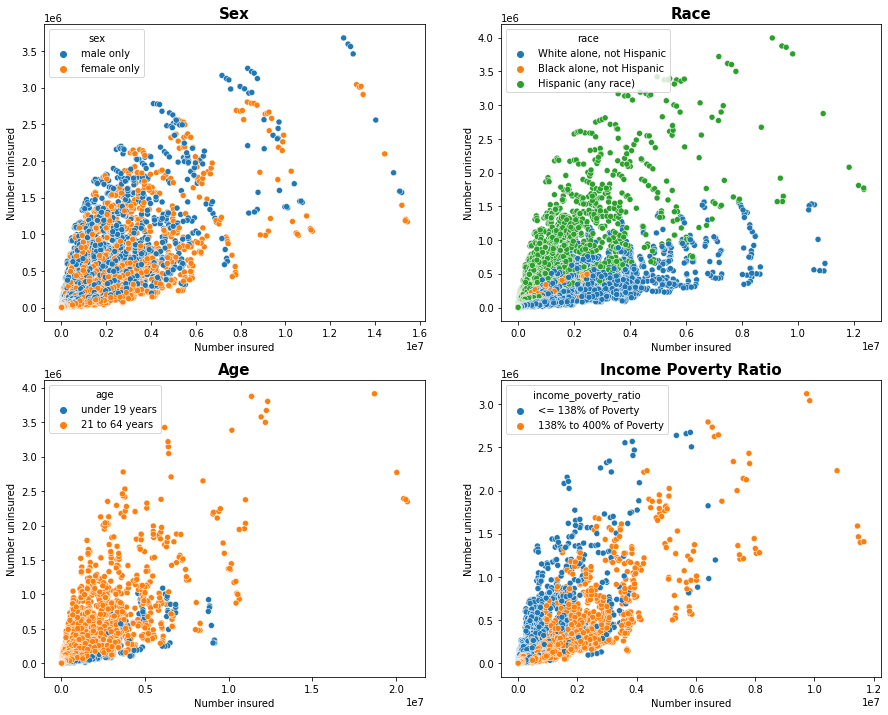

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, ncols=2, figsize=(15,12))

sns.scatterplot(data=by_sex, x="number_insured", y="number_uninsured", hue="sex", ax=ax1)
ax1.set_ylabel("Number uninsured")
ax1.set_xlabel("Number insured")
ax1.set_title("Sex",fontdict= {'fontsize': 15, 'fontweight':'bold'})
sns.scatterplot(data=by_race, x="number_insured", y="number_uninsured", hue="race", ax=ax2)
ax2.set_ylabel("Number uninsured")
ax2.set_xlabel("Number insured")
ax2.set_title("Race",fontdict= {'fontsize': 15, 'fontweight':'bold'})
sns.scatterplot(data=by_age, x="number_insured", y="number_uninsured", hue="age", ax=ax3)
ax3.set_ylabel("Number uninsured")
ax3.set_xlabel("Number insured")
ax3.set_title("Age",fontdict= {'fontsize': 15, 'fontweight':'bold'})
sns.scatterplot(data=by_ipr, x="number_insured", y="number_uninsured", hue="income_poverty_ratio", ax=ax4)
ax4.set_ylabel("Number uninsured")
ax4.set_xlabel("Number insured")
ax4.set_title("Income Poverty Ratio",fontdict= {'fontsize': 15, 'fontweight':'bold'})

The top left plot shows us that, normally, more females have heatlh insurance than males. And we can see that there is a huge discrepancy between White (not hispanic) and Hispanic (any race) in having health insurance. Generally, the ratio of Caucasians who have health insurance is much higher than that of the ratio of the Hispanics. Also, the bottom left plot indicates that the uninsured rates of younger people (teenagers) is lower. And lastly, we can observe that the uninsured rates of groups, of which poverty ratio is above 138%, is lower than those that the ratio is lower than 138%.  

In [15]:
sql_query_1 = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where sex in ('male only', 'female only')
group by sex
"""

sql_query_2 = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where race in ('White alone, not Hispanic', 'Black alone, not Hispanic', 'Hispanic (any race)')
group by race
"""

sql_query_3 = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where age in ('under 19 years', '21 to 64 years')
group by age
"""

sql_query_4 = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where income_poverty_ratio in ('<= 138% of Poverty', '138% to 400% of Poverty')
group by income_poverty_ratio
"""

In [16]:
# Sex
print(pd.read_sql_query(sql_query_1, healthinsurance_conn)) #0: female / 1: male

   Insured ratio  Uninsured ratio
0       0.794267         0.205733
1       0.750773         0.249227


In [17]:
# Race
print(pd.read_sql_query(sql_query_2, healthinsurance_conn)) #0: Black alone, not Hispanic / 1: Hispanic (any race) / 2: White alone, not Hispanic

   Insured ratio  Uninsured ratio
0       0.812444         0.187556
1       0.653388         0.346612
2       0.826196         0.173804


In [18]:
# Age
print(pd.read_sql_query(sql_query_3, healthinsurance_conn)) #0: 21 to 64 years / 1: under 19 years

   Insured ratio  Uninsured ratio
0       0.779976         0.220024
1       0.926588         0.073412


In [19]:
# Income Poverty Ratio
print(pd.read_sql_query(sql_query_4, healthinsurance_conn)) #0: 138% to 400% of Poverty / 1: <= 138% of Poverty

   Insured ratio  Uninsured ratio
0       0.830684         0.169316
1       0.723583         0.276417


we can numerically see uninsured ratios for different sex, race, age, and income poverty ratio. For instance, the uninsured ratio of females is 0.205 while the uninsured ratio of males is 0.249. 

In [20]:
sql_query_by_ipr = """
select income_poverty_ratio, ratio_uninsured
from healthinsurance
where income_poverty_ratio not in ('All Incomes', '138% to 400% of Poverty')
"""
by_ipr = pd.read_sql_query(sql_query_by_ipr, healthinsurance_conn)

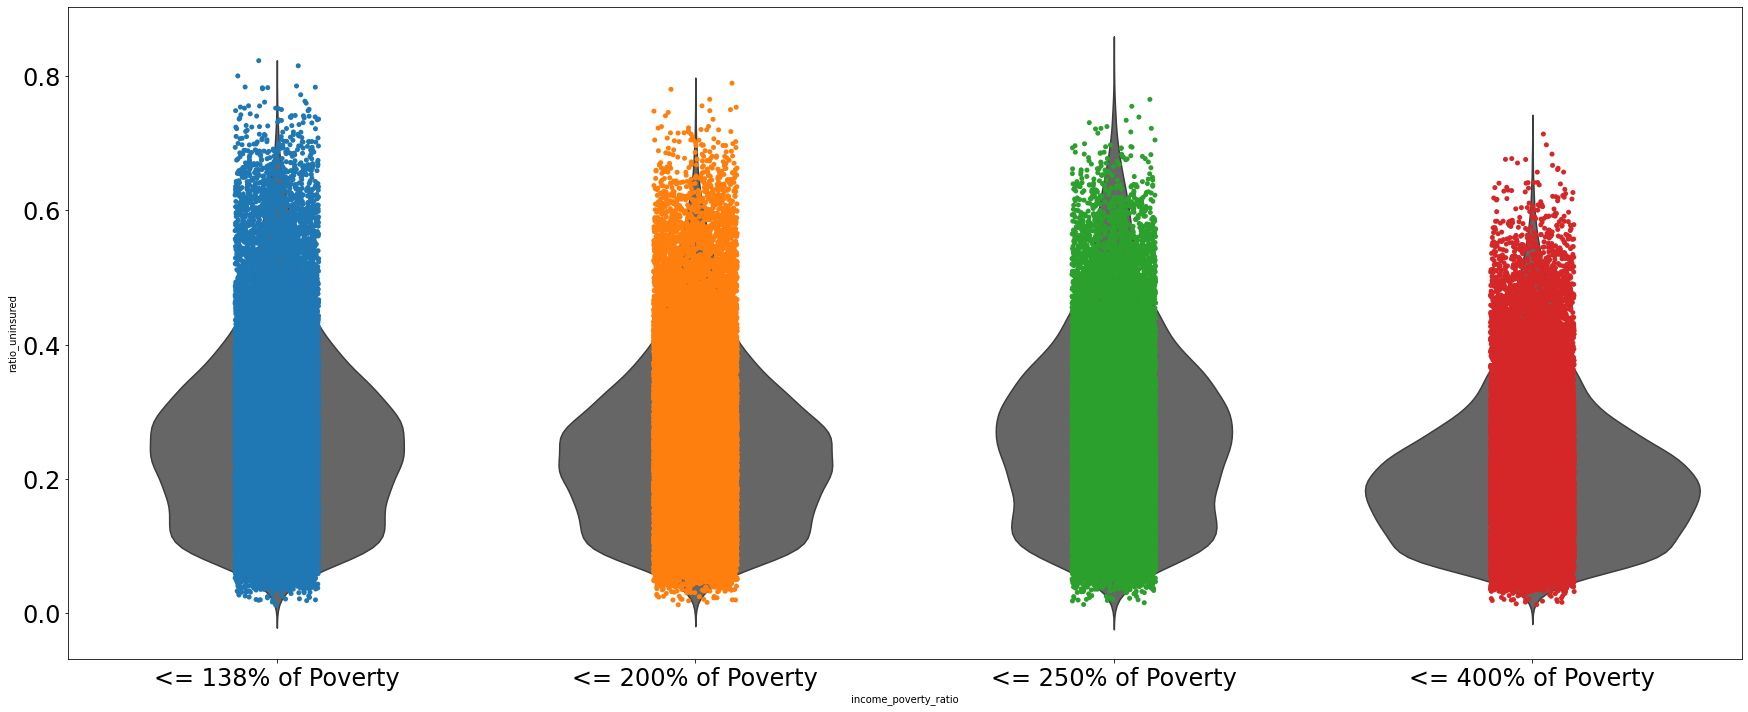

In [21]:
fig, ax = plt.subplots(figsize=(30, 12))
ax = sns.violinplot(x= "income_poverty_ratio", y="ratio_uninsured", data=by_ipr, inner=None, color="0.4")
ax = sns.stripplot(x= "income_poverty_ratio", y="ratio_uninsured", data=by_ipr, order=["<= 138% of Poverty", "<= 200% of Poverty", "<= 250% of Poverty", "<= 400% of Poverty"])
ax.tick_params(labelsize=24)

Considering that each level contains the previous level (e.g. '<= 200% of Poverty' includes '<= 138% of Poverty'), we can observe a clear pattern that, as the income poverty ratio increases, the uninsured ratio decreases. 

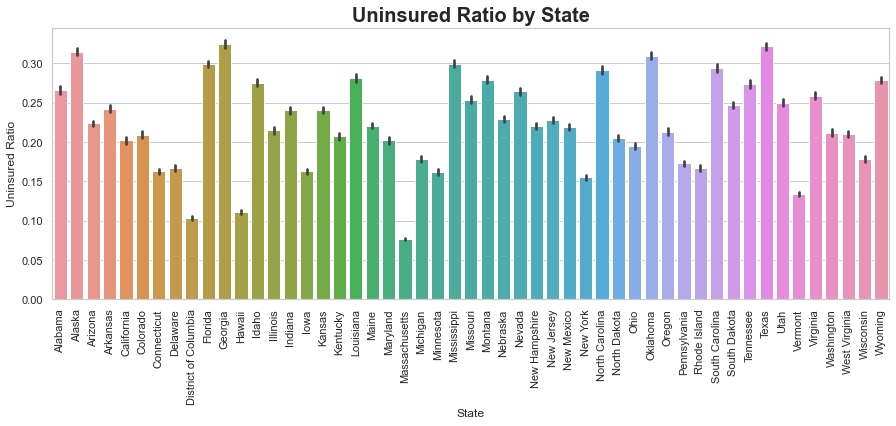

In [22]:
# Uninsured Ratio by state

sql_query_by_state = """
select states, ratio_uninsured
from healthinsurance
"""
by_state = pd.read_sql_query(sql_query_by_state, healthinsurance_conn)

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(15,5))
bar_plot = sns.barplot(data=by_state, x="states", y="ratio_uninsured")

bar_plot.set(xlabel="State", ylabel = "Uninsured Ratio")
bar_plot.set_title('Uninsured Ratio by State',fontdict= {'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=90)

plt.show()

This bar plot shows us that only a few states have uninsured rates of less than 0.15. We can observe that Massachusetts has the lowest uninsured ratio. On the other hand, Alaska, Georgia, and Texas have the highest uninsured ratio (greater than 0.3) in the United States.

In [23]:
# 5 States with the highest and lowest uninsured ratios

state_uninsured_ratio = by_state.groupby("states").mean()

state_uninsured_ratio.sort_values(by=['ratio_uninsured'], inplace=True, ascending=False)
print(state_uninsured_ratio.head(5))    # 5 states with highest uninsured ratio
print(state_uninsured_ratio.tail(5))    # 5 states with lowest uninsured ratio

             ratio_uninsured
states                      
Georgia             0.324482
Texas               0.321669
Alaska              0.315010
Oklahoma            0.310012
Mississippi         0.299863
                      ratio_uninsured
states                               
New York                     0.155077
Vermont                      0.133748
Hawaii                       0.111072
District of Columbia         0.103565
Massachusetts                0.076547


Georgia has the highest uninsured ratio, which is 0.324, followed by Texas, Alaska, Oklahoma, and Mississippi. They all have approximately 0.30 of uninsured ratios. And New York, Vermont, Hawaii, DC, and Massachusetts are five of the states that have lowest uninsured ratios. But we can notice that the uninsured ratio of New York is twice as large as Massachusetts. 

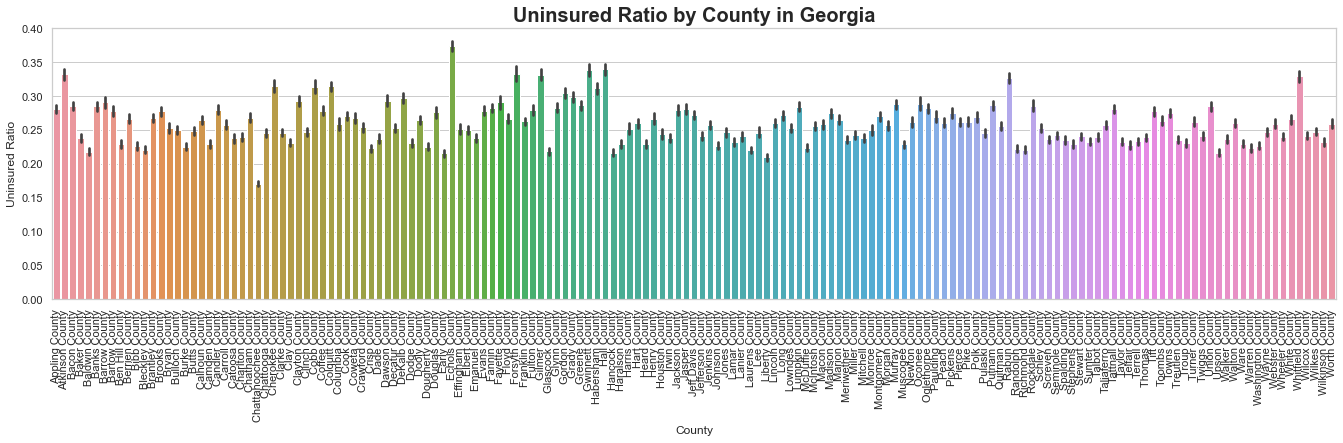

In [24]:
# Uninsured ratio by county in Georgia

sql_query_by_county_ga = """
select NAME, ratio_uninsured
from healthinsurance_ga
"""
by_county_ga = pd.read_sql_query(sql_query_by_county_ga, healthinsurance_ga_conn)

# Store only county names (e.g. Appling County, GA => Appling County)
by_county_ga['county'] = by_county_ga['NAME'].str.split(',').str[0]

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(23,5))
bar_plot = sns.barplot(data=by_county_ga, x="county", y="ratio_uninsured")

bar_plot.set(xlabel="County", ylabel = "Uninsured Ratio")
bar_plot.set_title('Uninsured Ratio by County in Georgia',fontdict= {'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=90)

plt.show()

In Georgia, almost every county has greater 0.22 of uninsured ratio which is the national average. Especially, the Echols County has the highest uninsured ratio, recording almost 0.40. On the other hand, the Chattahoochee County has the lowest uninsured ratio in Georgia, which is approximately 0.17.  

In [25]:
# ratio of insured/uninsured by year in the US
sql_query_by_year = """
select income_poverty_ratio, year, ratio_uninsured
from healthinsurance
where (income_poverty_ratio = '138% to 400% of Poverty' or income_poverty_ratio = '<= 138% of Poverty') and year not in ('2010', '2011')

"""
by_year = pd.read_sql_query(sql_query_by_year, healthinsurance_conn)


# ratio of insured/uninsured by year in Georgia
sql_query_by_year_ga = """
select income_poverty_ratio, year, ratio_uninsured
from healthinsurance_ga
where (income_poverty_ratio = '138% to 400% of Poverty' or income_poverty_ratio = '<= 138% of Poverty') and year not in ('2010', '2011')

"""
by_year_ga = pd.read_sql_query(sql_query_by_year_ga, healthinsurance_ga_conn)

Text(0.5, 1.0, 'Uninsured Ratio Based on Year & Income Poverty Ratio in Georgia')

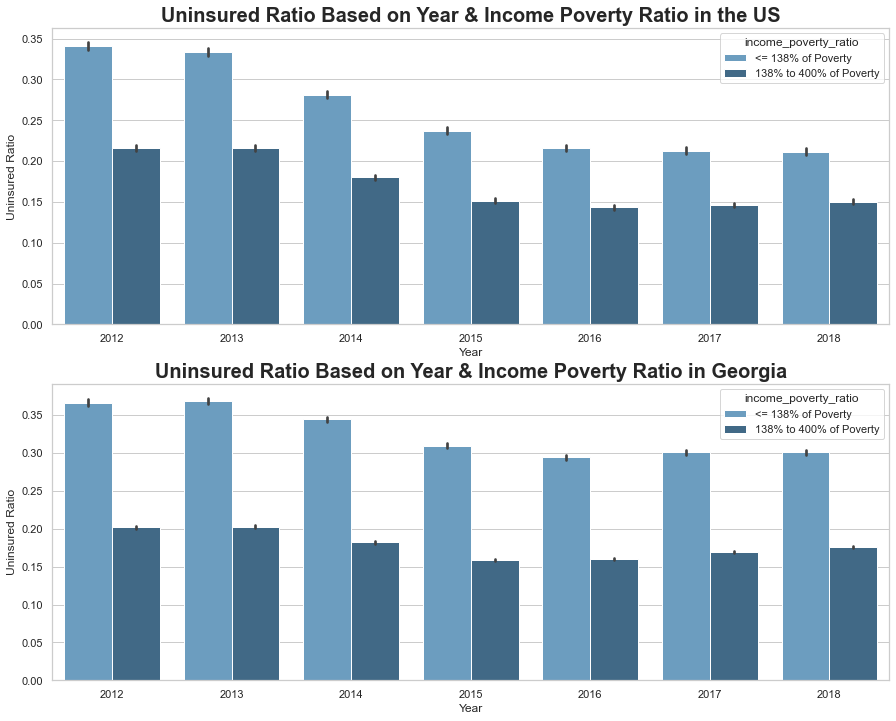

In [26]:
fig, ((ax1), (ax2)) = plt.subplots(2, ncols=1, figsize=(15,12))

sns.barplot(data=by_year, x="year", y="ratio_uninsured", hue="income_poverty_ratio", palette="Blues_d", ax=ax1)
ax1.set(xlabel="Year", ylabel = "Uninsured Ratio")
ax1.set_title('Uninsured Ratio Based on Year & Income Poverty Ratio in the US',fontdict= {'fontsize': 20, 'fontweight':'bold'})

sns.barplot(data=by_year_ga, x="year", y="ratio_uninsured", hue="income_poverty_ratio", palette="Blues_d", ax=ax2)
ax2.set(xlabel="Year", ylabel = "Uninsured Ratio")
ax2.set_title('Uninsured Ratio Based on Year & Income Poverty Ratio in Georgia',fontdict= {'fontsize': 20, 'fontweight':'bold'})


In the United States, from 2012 to 2016, the uninsured ratios has clearly decreased for both the groups divided based on the income poverty ratio. And they remained almost the same between 2016 and 2018. However, the decreasing trend for the two groups are slightly different. While the uninsured ratio for a group with less than 138% poverty ratio has decreased by 0.13 (approximately from 0.34 to 0.21), the ratio of the other group has decreased by 0.06 (approximately from 0.21 to 0.15). And it even has slightly increased in 2018. 

In the second plot, we can observe that the ratio in 2012 in Georgia is very similar to the US ratio. However, the ratios for the both groups in Georgia did not decrease much. We can observe that, in 2018, the ratio gap between the two groups is still very large. 

Text(0.5, 1.0, 'Massachusetts (Lowest uninsured ratio)')

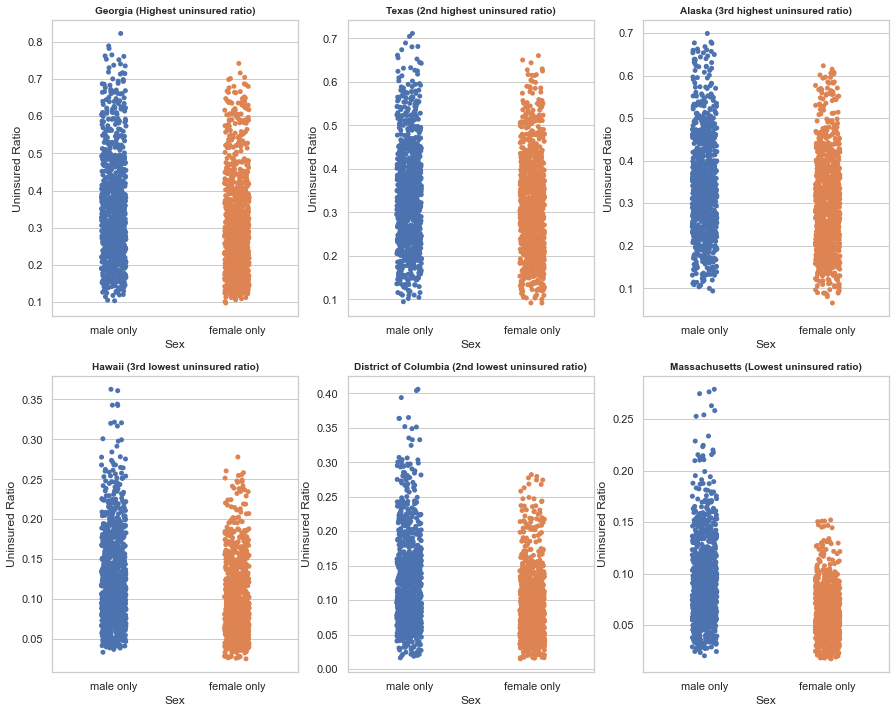

In [29]:
# Sex and state 

sql_query_by_sex_state = """
select race, ratio_uninsured, states, sex
from healthinsurance
where states in ('Georgia', 'Texas', 'Alaska', 'Massachusetts', 'District of Columbia', 'Hawaii') and sex in ('male only', 'female only')
"""
by_sex_state = pd.read_sql_query(sql_query_by_sex_state, healthinsurance_conn)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, ncols=3, figsize=(15,12))


# Georgia
sns.stripplot(x=by_sex_state[by_sex_state['states']=='Georgia']['sex'], y=by_sex_state[by_sex_state['states']=='Georgia']['ratio_uninsured'], ax=ax1)
ax1.set_ylabel("Uninsured Ratio")
ax1.set_xlabel("Sex")
ax1.set_title("Georgia (Highest uninsured ratio)",fontdict= {'fontsize': 10, 'fontweight':'bold'})

# Texas
sns.stripplot(x=by_sex_state[by_sex_state['states']=='Texas']['sex'], y=by_sex_state[by_sex_state['states']=='Texas']['ratio_uninsured'], ax=ax2)
ax2.set_ylabel("Uninsured Ratio")
ax2.set_xlabel("Sex")
ax2.set_title("Texas (2nd highest uninsured ratio)",fontdict= {'fontsize': 10, 'fontweight':'bold'})

# Alaska
sns.stripplot(x=by_sex_state[by_sex_state['states']=='Alaska']['sex'], y=by_sex_state[by_sex_state['states']=='Alaska']['ratio_uninsured'], ax=ax3)
ax3.set_ylabel("Uninsured Ratio")
ax3.set_xlabel("Sex")
ax3.set_title("Alaska (3rd highest uninsured ratio)",fontdict= {'fontsize': 10, 'fontweight':'bold'})

# Hawaii
sns.stripplot(x=by_sex_state[by_sex_state['states']=='Hawaii']['sex'], y=by_sex_state[by_sex_state['states']=='Hawaii']['ratio_uninsured'], ax=ax4)
ax4.set_ylabel("Uninsured Ratio")
ax4.set_xlabel("Sex")
ax4.set_title("Hawaii (3rd lowest uninsured ratio)",fontdict= {'fontsize': 10, 'fontweight':'bold'})

# District of Columbia
sns.stripplot(x=by_sex_state[by_sex_state['states']=='District of Columbia']['sex'], y=by_sex_state[by_sex_state['states']=='District of Columbia']['ratio_uninsured'], ax=ax5)
ax5.set_ylabel("Uninsured Ratio")
ax5.set_xlabel("Sex")
ax5.set_title("District of Columbia (2nd lowest uninsured ratio)",fontdict= {'fontsize': 10, 'fontweight':'bold'})

# Massachusetts
sns.stripplot(x=by_sex_state[by_sex_state['states']=='Massachusetts']['sex'], y=by_sex_state[by_sex_state['states']=='Massachusetts']['ratio_uninsured'], ax=ax6)
ax6.set_ylabel("Uninsured Ratio")
ax6.set_xlabel("Sex")
ax6.set_title("Massachusetts (Lowest uninsured ratio)",fontdict= {'fontsize': 10, 'fontweight':'bold'})

In the states where the overall uninsured ratios are high (e.g. Georgia, Texas, and Alaska), males and females have similar ranges in terms of the uninsured ratio. Both of their ranges are very wide covering from 0.1 to 0.7. However, in the states where the overall uninsured ratios are low (e.g. Hawaii, DC, and Massachusetts), the differences between males and females become quite large. For instance, in Massachusetts, while the uninsured ratio of females ranges approximately from 0.02 to 0.15, the uninsured ratio of males ranges from 0.02 to 0.3, which is much wider than the females.  

Based on the observations, We can infer people who are male Hispanics with a less than 138% of poverty income ratio in Georgia have the highest chance to not have health insurance. Since Massachusetts has the lowest uninsured ratio in the United States, we can compare how the uninsured ratios differ under the same conditions. 

In [30]:
# Conditions that possibly generate highest uninsured ratio

sql_query_highest_GA = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where income_poverty_ratio = '<= 138% of Poverty' and states = 'Georgia' and sex = 'male only' and race = 'Hispanic (any race)'
"""
print(pd.read_sql_query(sql_query_highest_GA, healthinsurance_conn))   # Georgia


sql_query_highest_MA = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where income_poverty_ratio = '<= 138% of Poverty' and states = 'Massachusetts' and sex = 'male only' and race = 'Hispanic (any race)'
"""
print(pd.read_sql_query(sql_query_highest_MA, healthinsurance_conn))   # Massachusetts 

   Insured ratio  Uninsured ratio
0       0.387822         0.612178
   Insured ratio  Uninsured ratio
0       0.855342         0.144658


Even though they have the same conditions except the States, the uninsured ratio in Georgia is approximately 4 times greater than Massachusetts. 

In [31]:
# Conditions that possibly generate lowest uninsured ratio

sql_query_lowest = """
select avg(ratio_insured) as 'Insured ratio', avg(ratio_uninsured) as 'Uninsured ratio'
from healthinsurance
where income_poverty_ratio = '138% to 400% of Poverty' and states = 'Massachusetts' and sex = 'female only' and race = 'White alone, not Hispanic'
"""
print(pd.read_sql_query(sql_query_lowest, healthinsurance_conn))

   Insured ratio  Uninsured ratio
0       0.959261         0.040739


In [32]:
sql_query_highest_GA_by_year = """
select age, year, ratio_uninsured
from healthinsurance
where income_poverty_ratio = '<= 138% of Poverty' and states = 'Georgia' and sex = 'male only' and race = 'Hispanic (any race)' and age not in ('under 65 years', '21 to 64 years')
"""
highest_GA_by_year = pd.read_sql_query(sql_query_highest_GA_by_year, healthinsurance_conn)

Text(0.5, 1.0, 'Uninsured Ratio of Hispanic males w/ low IPR in Georgia')

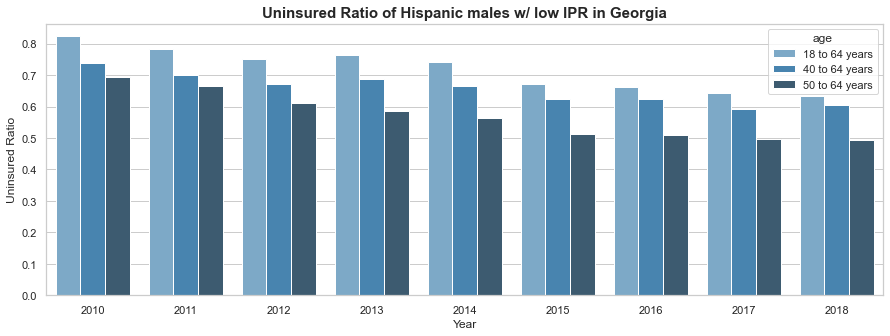

In [33]:
fig, ax1 = plt.subplots(1, ncols=1, figsize=(15,5))

sns.barplot(data=highest_GA_by_year, x="year", y="ratio_uninsured", hue="age", palette="Blues_d", ax=ax1)
ax1.set(xlabel="Year", ylabel = "Uninsured Ratio")
ax1.set_title('Uninsured Ratio of Hispanic males w/ low IPR in Georgia',fontdict= {'fontsize': 15, 'fontweight':'bold'})


And we can see the trend of the uninsured ratio of Hispanic males with low IPR in Georgia keeps decreasing over all the age categories, but it is still much higher than the national average level. 

__4. Conclusion:__

This project explored various features such as age group, sex, income poverty ratio, ethnicity, etc. And we observed that among the features, income poverty ratio, state, and ethnicity particularly play big roles influencing the uninsured ratio. 

The uninsured ratio is high when the income poverty ratio is low. And among all the ethnicity groups, Hispanics have the highest uninsured ratio. Also, Georgia has the highest uninsured ratio in the United States. 

Through this context, we can conclude that the Hispanics in Georgia with low income poverty ratio do not have enough opportunity to have health insurance. Therefore, the state of Georgia can benchmark existing laws or programs regarding health insurance currently being used in states with low uninsured ratio, and try to give a more suitable opportunity to those uninsured people. 

By reducing the uninsured ratio in the United States, we could potentially reduce the number of bankrupcies occurred due to health care costs. 